## 介绍
淘宝作为国内最大电商平台之一，淘宝上有大量的买家。为了吸引大量的新买家，商家有时会在特定的日期（6.18、双11等）进行大促销。但是同时，有许多被吸引的新买家是一次性买家，而商家并不能将这批新买家转化为忠实客户。为了提高ROI，淘宝提供用户行为日志帮助分析可能可以转化为忠实客户的买家。
数据集来自于[天池](https://tianchi.aliyun.com/dataset/dataDetail?dataId=47).


## 目标
分析网站各项指标（UV,PV,etc），客户群分类并给出营销策略

## Table of contents
* [Importing libraries](#lib)
* [Read in the dataset](#read)
* [Data cleaning](#clean)
* [Analysis](#ana)
* [Tags Sentimental Analysis](#nltk)

## <a name="lib"></a>Importing libraries

In [1]:
import pandas as pd
import numpy as np
import pymysql
import matplotlib.pyplot as plt
import seaborn as sns
import plotnine as p9
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.set_option('precision', 3)
sns.set_style("whitegrid")
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['font.family']='sans-serif'
plt.rcParams['axes.unicode_minus'] = False

## <a name="read"></a>Read in the dataset

In [3]:
files_path = os.getcwd()

In [4]:
conn = pymysql.connect(host = 'localhost', user = 'root', passwd = '8625649', db = 'ub')
df = pd.read_sql('select * from user_log_format1', conn)

In [5]:
uinfo = pd.read_csv(files_path + '//data_format1//user_info_format1.csv')

## <a name="clean"></a> Data cleaning
### Goals:
- Convert features into right data types
- Deal with NA value
- Create possibly useful new features

In [464]:
df.info(), uinfo.info(), df.tail(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 800717 entries, 0 to 800716
Data columns (total 10 columns):
user_id        800717 non-null object
item_id        800717 non-null object
cat_id         800717 non-null object
seller_id      800717 non-null object
brand_id       799674 non-null object
time_stamp     800717 non-null object
action_type    800717 non-null object
month          800717 non-null int64
day_of_week    800717 non-null int64
day            800717 non-null int64
dtypes: int64(3), object(7)
memory usage: 67.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 424170 entries, 0 to 424169
Data columns (total 3 columns):
user_id      424170 non-null object
age_range    421953 non-null float64
gender       424170 non-null object
dtypes: float64(1), object(2)
memory usage: 9.7+ MB


(None,
 None,
        user_id item_id cat_id seller_id brand_id time_stamp action_type  \
 800707  402892  633031    177       267     1181       1111       click   
 800708  402892  908639    662      4954     3712       1111       click   
 800709  402892  676866   1505      3760     3738       0712       click   
 800710  402892  256559   1505      3760     3738       0712       click   
 800711  402892  572114   1505      3760     3738       0712       click   
 800712  402892  715126    662       416     4014       0712       click   
 800713  402892  160265    302      4299     1012       0712       click   
 800714  402892  356228    821       373     4743       0820       click   
 800715  402892   74488    737       649     5891       0820       click   
 800716  402892  578568   1095      1340     1981       0618       click   
 
         month  day_of_week  day  
 800707     11            6   11  
 800708     11            6   11  
 800709      7            3   12  
 800710 

- 用户年龄段: 1 for <18; 2 for [18,24]; 3 for [25,29]; 4 for [30,34]; 5 for [35,39]; 6 for [40,49]; 7 and 8 for >= 50;
- 用户性别: 0 for female, 1 for male, 2 and NULL for unknown.
- 因为最后一名用户没有包含双11的数据，所以drop掉

In [7]:
uinfo['user_id'] = uinfo.user_id.apply(str)
uinfo['gender'].replace(0, 'female', inplace = True)
uinfo['gender'].replace(1, 'male', inplace = True)
uinfo['gender'].replace([2], 'unknown', inplace = True)
uinfo['gender'].fillna('unknown', inplace = True)

df['action_type'].replace('0','click',inplace=True)
df['action_type'].replace('1','cart',inplace=True)
df['action_type'].replace('2','buy',inplace=True)
df['action_type'].replace('3','fav',inplace=True)

df['month'] = pd.to_datetime(df.time_stamp, format = '%m%d').dt.month
df['day_of_week'] = pd.to_datetime(df.time_stamp, format = '%m%d').dt.dayofweek
df['day'] = pd.to_datetime(df.time_stamp, format = '%m%d').dt.day


df = df[~(df['user_id'] == '343175')]
full_df = df.merge(uinfo, on = 'user_id', how = 'left')

## <a name = 'ana'></a> Analysis

### 淘宝月维度流量分析

In [8]:
mpv = full_df.query('action_type == "click"').groupby('month')['user_id'].size().reset_index(name = 'pv')
muv = full_df.drop_duplicates('user_id').groupby('month')['user_id'].size().reset_index(name = 'uv')
pv_uv = pd.merge(mpv,muv)
pv_uv['ratio'] = pv_uv.pv / pv_uv.uv
pv_uv

,month,pv,uv,ratio
0,5,36412,306,118.993
1,6,94213,674,139.782
2,7,68784,567,121.312
3,8,66622,553,120.474
4,9,77991,663,117.633
5,10,100376,855,117.399
6,11,263048,1707,154.100


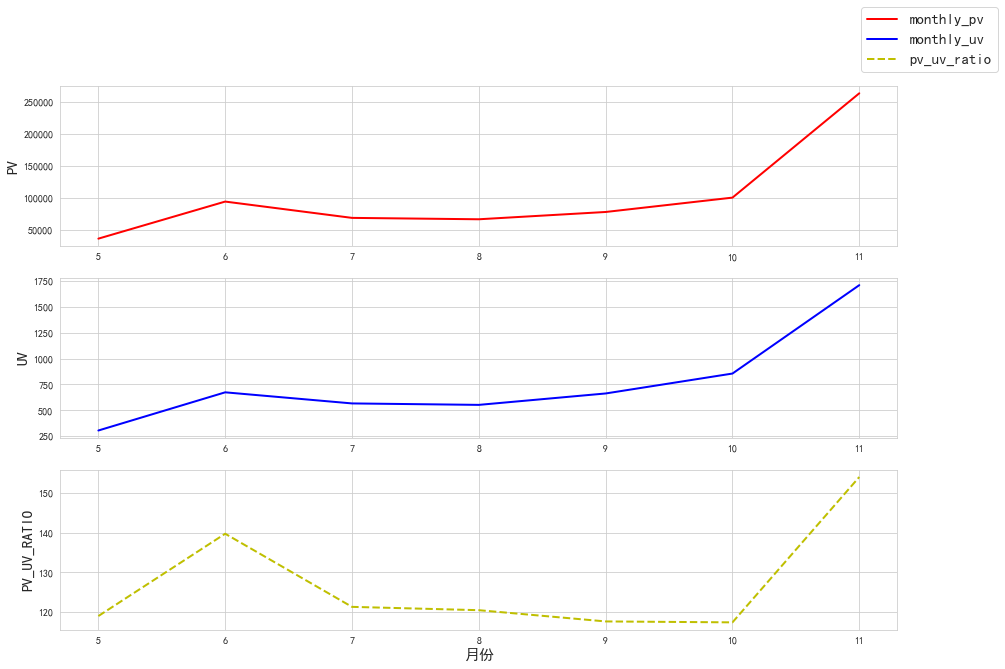

In [9]:
fig = plt.figure(figsize = (15, 10))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)
ax1.plot(pv_uv.month, pv_uv.pv, c = 'r', linewidth = '2', label = 'monthly_pv')
ax1.set_ylabel('PV', fontsize = 15)
ax2.plot(pv_uv.month, pv_uv.uv, c = 'b', linewidth = '2', label = 'monthly_uv')
ax2.set_ylabel('UV', fontsize = 15)
ax3.plot(pv_uv.month, pv_uv.ratio, c = 'y', linewidth = '2', linestyle= 'dashed', label = 'pv_uv_ratio')
ax3.set_ylabel('PV_UV_RATIO', fontsize = 15)
ax3.set_xlabel('月份', fontsize = 15)

fig.legend(fontsize = 15)
plt.show()

In [484]:
full_df.query('action_type == "click"').groupby(['time_stamp'])['user_id'].size().reset_index(name = 'click').sort_values('click',ascending = False).head(20)

,time_stamp,click
175,1111,137173
174,1110,39059
173,1109,13629
172,1108,12005
171,1107,11620
170,1106,11044
168,1104,9525
37,0626,9334
169,1105,9331
165,1101,6835


6月份和11月份的PV_UV比例最高，表示6月和11月份的用户活跃度高，每个用户的点击网页次数相对其他月份多得多。同时可以看到点击次数最高的前20个日期大部分都在11月份以及10月末，6月18号前后的日期点击次数也有优秀表现。

### 转化率分析

In [485]:
cart_fav = full_df.query('action_type == "cart" or action_type == "fav"').groupby('month')['user_id'].size().reset_index(name = 'cart&fav')
buy = full_df.query('action_type == "buy"').groupby('month')['user_id'].size().reset_index(name = 'buy') 
action_df = mpv.merge(pd.merge(cart_fav, buy)).rename(columns = {'pv' : 'click'})
action_df['cf/click'] = action_df['cart&fav'] / action_df['click']
action_df['buy/click'] = action_df.buy / action_df['click']

,month,click,cart&fav,buy,cf/click,buy/click
0,5,36412,3226,4409,0.089,0.121
1,6,94213,4734,5902,0.050,0.063
2,7,68784,3426,5350,0.050,0.078
3,8,66622,3864,4900,0.058,0.074
4,9,77991,4975,5702,0.064,0.073
5,10,100376,7862,6617,0.078,0.066
6,11,263048,11442,20862,0.043,0.079


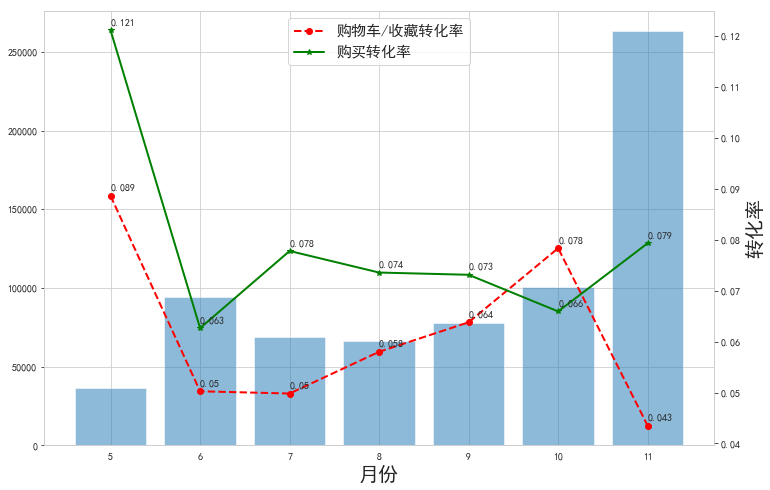

In [486]:
fig = plt.figure(figsize = (12,8))

x = action_df.month
y1 = action_df.click
y2 = action_df['cf/click']
y3 = action_df['buy/click']

ax1 = fig.add_subplot(111)
ax1.bar(x, y1, alpha = 0.5)
ax1.set_xlabel('月份', fontsize = 20)

ax2 = ax1.twinx()
ax2.plot(x, y2, linewidth = 2, c = 'r', marker = 'o', linestyle = 'dashed', label = '购物车/收藏转化率')
ax2.set_ylabel('转化率', fontsize = 20)
plt.plot(x, y3, linewidth = 2, c = 'g', marker = '*', label = '购买转化率')

for x,y,z in zip(x, y2, y3):
    plt.annotate(round(y, 3), xy = (x,y), xytext = (x,y + 0.001))
    plt.annotate(round(z, 3), xy = (x,z), xytext = (x,z + 0.001))

plt.legend(loc = 9,fontsize = 15)
plt.grid(False)

action_df

从7月份到10月份，购买率逐渐下降，收藏和购物车转化率上升。消费者是否从7月份开始就准备双11？和上面的活跃度做对比

In [162]:
day_sales = full_df.query('action_type == "buy"').groupby('time_stamp').size().reset_index(name = 'count').sort_values('count', ascending = False)
print("双11当天销量占总销量的{}".format(day_sales['count'].tolist()[0] / sum(day_sales['count'].tolist())))

双11当天销量占总销量的0.35629489040229245


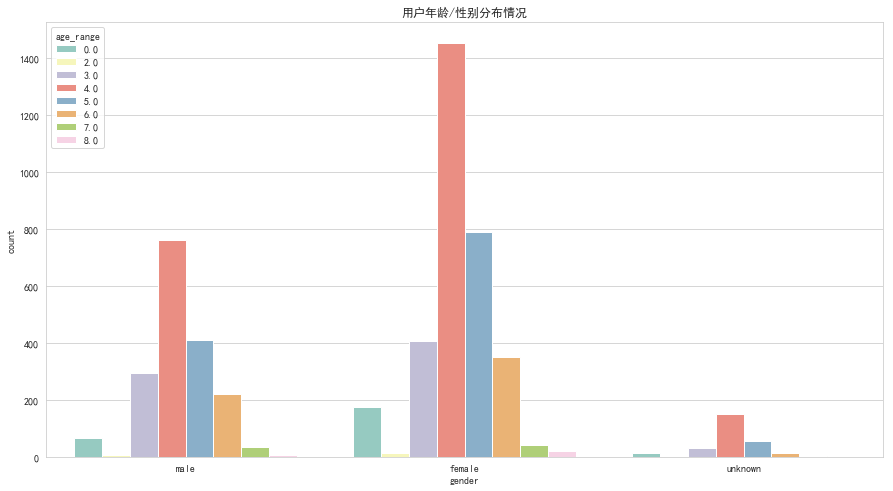

In [78]:
data = full_df.drop_duplicates('user_id', keep = 'last')
fig = plt.figure(figsize = (15,8))
sns.countplot(x = 'gender', hue = 'age_range', data = data, palette = 'Set3')
plt.title('用户年龄/性别分布情况')
plt.show()

25到39岁为用户的主要年龄段，又以30到34岁年龄段为最多人群。女性用户比男性用户多近一倍。

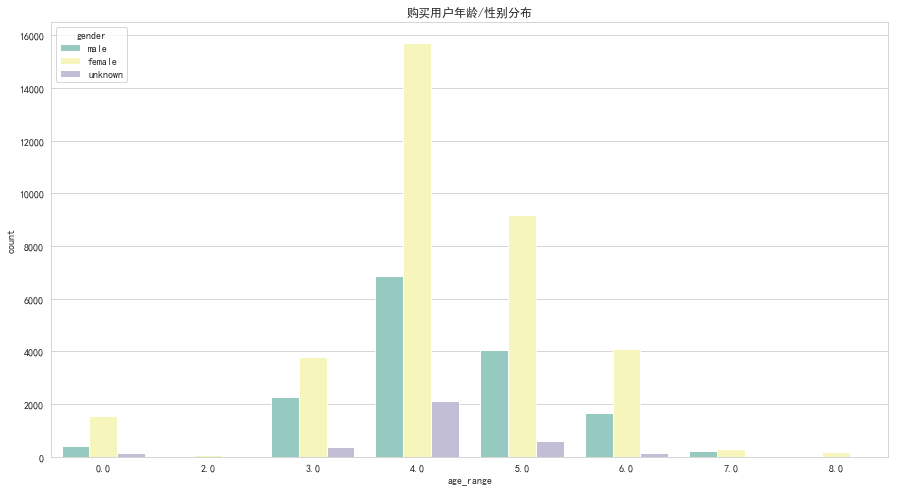

In [77]:
fig = plt.figure(figsize = (15,8))
sns.countplot(x = 'age_range', hue = 'gender', data = full_df.query('action_type == "buy"'), palette = 'Set3')
plt.title('购买用户年龄/性别分布')
plt.show()

30到39岁为主要消费人群，同时其中女性占大多数。

In [99]:
cdf = full_df.query('action_type == "click"')
bdf = full_df.query('action_type == "buy"')

In [102]:
def view_buy(col):
    view = cdf.groupby(col + '_id').size().reset_index(name = 'top_view').sort_values('top_view', ascending = False).head(5)
    buy = bdf.groupby(col + '_id').size().reset_index(name = 'top_buy').sort_values('top_buy', ascending = False).head(5)
    return view, buy

In [107]:
cat_view, cat_buy = view_buy('cat')
cat_view

,cat_id,top_view
924,662,49071
271,1349,27808
989,737,22229
873,602,20509
396,1505,18736


In [101]:
cat_buy

,cat_id,top_buy
147,1213,1782
489,267,1542
697,602,1367
259,1401,1298
739,662,1249


被浏览次数最多的类目是类目924，但是前五被购买次数最多得类目里面并没有类目924

In [114]:
item_view, item_buy = view_buy('item')
item_view

,item_id,top_view
134473,67897,7837
126063,636863,3666
155045,783997,3062
124518,628774,1164
4871,1024557,1005


In [115]:
item_buy

,item_id,top_buy
20232,631714,78
976,1029992,75
6266,195714,68
18883,590204,49
23025,718528,47


商品20232，976, 6266销量最为突出，但是同样的，这些商品的浏览量并没有在前五里面。思考背后的原因

## Kmeans 用户分类

In [186]:
from sklearn.cluster import KMeans
from sklearn import preprocessing

In [277]:
full_df['days'] = 12 - full_df.month
full_df = full_df.sort_values('days')
user_days = full_df.drop_duplicates('user_id', keep = 'last')[['user_id','days']]
user_click = full_df.query('action_type == "click"').groupby('user_id').size().reset_index(name = 'click')
temp1 = pd.merge(user_days, user_click, how = 'left').fillna(0)
user_cf = full_df.query('action_type == "cart" or action_type == "fav"').groupby('user_id').size().reset_index(name = 'cart/fav')
temp2 = pd.merge(temp1, user_cf, how = 'left').fillna(0)
user_buy = full_df.query('action_type == "buy"').groupby('user_id').size().reset_index(name = 'buy')
user_behave = pd.merge(temp2, user_buy, how = 'left').fillna(0)

user_behave.describe()

,days,click,cart/fav,buy
count,5325.000,5325.000,5325.000,5325.000
mean,6.320,132.854,7.423,10.092
std,1.169,183.701,16.873,9.480
min,1.000,0.000,0.000,1.000
25%,6.000,37.000,0.000,4.000
50%,7.000,77.000,1.000,7.000
75%,7.000,156.000,7.000,13.000
max,7.000,2967.000,289.000,152.000


In [447]:
user_behave['zclick'] = preprocessing.StandardScaler().fit_transform(user_behave[['click']])
user_behave['zcart/fav'] = preprocessing.StandardScaler().fit_transform(user_behave[['cart/fav']])
user_behave['zbuy'] = preprocessing.StandardScaler().fit_transform(user_behave[['buy']])
user_behave['zdays'] = preprocessing.StandardScaler().fit_transform(user_behave[['days']])
zuser_behave = user_behave[['zclick','zcart/fav', 'zbuy', 'zdays']]
zuser_behave.head(3), zuser_behave.describe()

(   zclick  zcart/fav   zbuy  zdays
 0  -0.696     -0.321 -0.854 -4.551
 1  -0.701     -0.440 -0.959 -4.551
 2  -0.326     -0.203 -0.537 -4.551,
           zclick  zcart/fav       zbuy      zdays
 count  5.325e+03  5.325e+03  5.325e+03  5.325e+03
 mean   4.679e-16 -1.282e-14 -6.579e-16  7.988e-15
 std    1.000e+00  1.000e+00  1.000e+00  1.000e+00
 min   -7.233e-01 -4.400e-01 -9.592e-01 -4.551e+00
 25%   -5.218e-01 -4.400e-01 -6.427e-01 -2.736e-01
 50%   -3.041e-01 -3.807e-01 -3.262e-01  5.819e-01
 75%    1.260e-01 -2.509e-02  3.067e-01  5.819e-01
 max    1.543e+01  1.669e+01  1.497e+01  5.819e-01)

In [488]:
model = KMeans(n_clusters = 4, n_jobs = 4, max_iter = 3000)
model.fit(user_behave[['zclick','zcart/fav', 'zbuy', 'zdays']])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=3000,
    n_clusters=4, n_init=10, n_jobs=4, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

0    3338
3    1100
2     748
1     139
dtype: int64

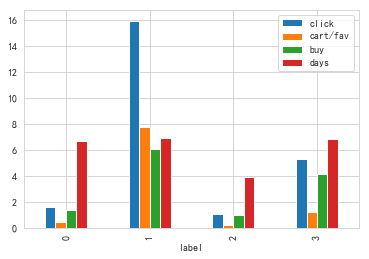

In [496]:
clusters = pd.concat([user_behave[['click','cart/fav', 'buy', 'days']], pd.Series(model.labels_)], axis = 1).rename(columns = {0:'label'}).groupby('label').mean()
clusters['buy'] = clusters.buy/5
clusters['click'] = clusters.click/50
clusters['cart/fav'] = clusters['cart/fav']/10
clusters.plot.bar()
pd.Series(model.labels_).value_counts()

5325名用户被分为了四类：
第一类：分类最多的用户，这类用户活跃月数多，浏览商品数少，但是浏览购买率较高。可以提高他们对淘宝的粘性，增加浏览次数
第二类：这类用户浏览商品数多，活跃月数多，同时购买数量大，这类客户是忠实客户
第三类：活跃月数最少，但是浏览购买率较高，这类用户活跃低，但是购买时目的性强
第四类：这类用户活跃月数多，浏览商品数量一般，但是浏览购买率较高。